In [81]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import boxplot
import itertools
from scipy import stats
import g4l

In [82]:
A = [0, 1, 2, 3, 4]
partition_string = '4' # para o exemplo linguistico
source_sample = g4l.data.Sample('./g4l/fixtures/folha.txt', A)
amnt_champion_trees = 16
amnt_new_samples = 200
sample_ratio_1 = 0.3
sample_ratio_2 = 0.9
len1 = int(len(source_sample.data) * sample_ratio_1)
len2 = int(len(source_sample.data) * sample_ratio_2)


In [83]:
def load_trees(dump_fld):
  bic_tree = g4l.tree.ContextTree.load(dump_fld, 'bic_tree')
  champion_trees = []
  for i in range(amnt_champion_trees):
    ch = g4l.tree.ContextTree.load(dump_fld, 'champion.%s' % i)
    champion_trees.append(ch)
  return (bic_tree, champion_trees)

def add_row(df, resample_idx, tree_idx, t, lml_small, lml):
  # lml = log maximum likelihood
  tree_str = t.to_str()
  df.loc[len(df)] = [resample_idx,
                     tree_idx,
                     t.chosen_penalty,
                     lml_small,
                     len(tree_str.split(' ')),
                     tree_str,
                     lml]

def calc_delta(df, sample_size, sample_length):
  df.sort_values(['sample_size', 'sample_idx', 'c'], inplace=True)
  for resample_idx in range(len(df.sample_idx.unique())):
    condition = (df.sample_size==sample_size) & (df.sample_idx==resample_idx)
    df.loc[condition, 'lml_next'] = (list(df.loc[condition].lml)[1:] + [float('NaN')])
    df.loc[condition, 'lml_delta'] = (df.loc[condition].lml - df.loc[condition].lml_next)
    df.loc[condition, 'lml_delta_div_n'] = df.loc[condition].lml_delta / sample_length**0.9

def calc_ttest(df):
  df2 = pd.DataFrame(columns=['tree_idx', 'tvalue','pvalue', 'sd_sm', 'sd_lg', 'num_contexts'])
  for tree_idx in df[df.lml_delta_div_n.notnull()].tree_idx.unique():
    delta_lml_sm = df[(df.sample_size=='sm') & (df.tree_idx == tree_idx)].lml_delta_div_n
    delta_lml_lg = df[(df.sample_size=='lg') & (df.tree_idx == tree_idx)].lml_delta_div_n
    ttest = stats.ttest_ind(delta_lml_sm, delta_lml_lg)
    num_contexts = list(df[df.tree_idx==tree_idx].num_contexts)[0]
    df2.loc[len(df2)] = [tree_idx, ttest.statistic, ttest.pvalue, delta_lml_sm.std(), delta_lml_lg.std(), num_contexts]
  return df2



In [84]:
fld = '/home/arthur/Documents/Neuromat/code/SMC/euclid.aoas.1331043393/supplementary/SCRIPTS/python/g4l/fixtures/dump'
bic_tree, champion_trees = load_trees(fld)
print('BIC Tree:', bic_tree.to_str())
print('# SMC Champion Trees:', len(champion_trees))


BIC Tree: 0000 001 0010 100 2 20 200 2000 201 2010 21 210 3 30 300 4
# SMC Champion Trees: 16


In [85]:
df = pd.DataFrame(columns=['sample_idx', 'tree_idx', 'c', 'sample_size', 'num_contexts', 'tree', 'lml'])
pbar = tqdm()
pbar.reset(total=amnt_new_samples)

resample_iterator = g4l.evaluation.resample(source_sample, amnt_new_samples, len1, partition_string)
for resample_idx, sample_small in enumerate(resample_iterator):
    pbar.update()
    for tree_idx, t in enumerate(champion_trees):
        add_row(df, resample_idx, tree_idx, t, 'sm', g4l.evaluation.LML(sample_small, t))
pbar.refresh()
pbar.reset(total=amnt_new_samples)

resample_iterator = g4l.evaluation.resample(source_sample, amnt_new_samples, len2, partition_string)
for resample_idx, sample_large in enumerate(resample_iterator):
    pbar.update()
    for tree_idx, t in enumerate(champion_trees):        
        add_row(df, resample_idx, tree_idx, t, 'lg', g4l.evaluation.LML(sample_large, t))
pbar.refresh()

/home/arthur/Documents/Neuromat/code/SMC/euclid.aoas.1331043393/supplementary/SCRIPTS/python/g4l/tree/__init__.py:124: RuntimeWarning: invalid value encountered in true_divide
  def children_freq_prob(self, node, node_freq):


True

In [86]:
df[df.sample_size=='sm'].head(50)

,sample_idx,tree_idx,c,sample_size,num_contexts,tree,lml
0,0,0,0.100000,sm,42,0000 0001 0010 002 0030 0102 012 0130 0201 021...,-21369
1,0,1,0.130510,sm,40,0000 0001 0010 002 0102 012 0130 0201 021 0210...,-21376
2,0,2,0.143094,sm,37,0000 0001 0010 002 0102 012 0130 0201 0210 03 ...,-21378
3,0,3,0.173601,sm,34,0000 0001 0010 002 0102 012 0130 0210 03 030 1...,-21383
4,0,4,0.191904,sm,27,0000 0001 0010 0130 0210 03 030 100 1210 13 2 ...,-21401
5,0,5,0.204105,sm,26,0000 0001 0010 0210 03 030 100 1210 13 130 2 2...,-21404
6,0,6,0.228506,sm,25,0000 001 0010 0210 03 030 100 1210 13 130 2 20...,-21411
7,0,7,0.241469,sm,22,0000 001 0010 0210 030 100 1210 130 2 20 200 2...,-21413
8,0,8,0.302467,sm,19,0000 001 0010 0210 100 1210 2 20 200 2000 201 ...,-21416
9,0,9,0.328388,sm,16,0000 001 0010 100 2 20 200 2000 201 2010 21 21...,-21422


In [87]:
calc_delta(df, 'sm', len1)
calc_delta(df, 'lg', len2)
df.head(20)


,sample_idx,tree_idx,c,sample_size,num_contexts,tree,lml,lml_next,lml_delta,lml_delta_div_n
3200,0,0,0.100000,lg,42,0000 0001 0010 002 0030 0102 012 0130 0201 021...,-64182,-64187.0,5,0.000177438
3201,0,1,0.130510,lg,40,0000 0001 0010 002 0102 012 0130 0201 021 0210...,-64187,-64191.0,4,0.00014195
3202,0,2,0.143094,lg,37,0000 0001 0010 002 0102 012 0130 0201 0210 03 ...,-64191,-64197.0,6,0.000212926
3203,0,3,0.173601,lg,34,0000 0001 0010 002 0102 012 0130 0210 03 030 1...,-64197,-64248.0,51,0.00180987
3204,0,4,0.191904,lg,27,0000 0001 0010 0130 0210 03 030 100 1210 13 2 ...,-64248,-64250.0,2,7.09752e-05
3205,0,5,0.204105,lg,26,0000 0001 0010 0210 03 030 100 1210 13 130 2 2...,-64250,-64259.0,9,0.000319388
3206,0,6,0.228506,lg,25,0000 001 0010 0210 03 030 100 1210 13 130 2 20...,-64259,-64262.0,3,0.000106463
3207,0,7,0.241469,lg,22,0000 001 0010 0210 030 100 1210 130 2 20 200 2...,-64262,-64274.0,12,0.000425851
3208,0,8,0.302467,lg,19,0000 001 0010 0210 100 1210 2 20 200 2000 201 ...,-64274,-64280.0,6,0.000212926
3209,0,9,0.328388,lg,16,0000 001 0010 100 2 20 200 2000 201 2010 21 21...,-64280,-64306.0,26,0.000922678


In [88]:
6906
97000

97000

In [89]:
df2 = calc_ttest(df)
df2

,tree_idx,tvalue,pvalue,sd_sm,sd_lg,num_contexts
0,0.0,13.763987,1.574435e-35,0.000183,0.000038,42.0
1,1.0,17.385521,8.981079e-51,0.000144,0.000040,40.0
2,2.0,13.161227,4.280959e-33,0.000191,0.000050,37.0
3,3.0,4.553612,7.019117e-06,0.000491,0.000121,34.0
4,4.0,13.034669,1.372434e-32,0.000111,0.000025,27.0
5,5.0,2.471059,1.388922e-02,0.000205,0.000049,26.0
6,6.0,17.668258,5.429880e-52,0.000156,0.000037,25.0
7,7.0,9.160181,2.773339e-18,0.000264,0.000066,22.0
8,8.0,12.606538,6.832286e-31,0.000187,0.000051,19.0
9,9.0,0.959354,3.379627e-01,0.000292,0.000064,16.0


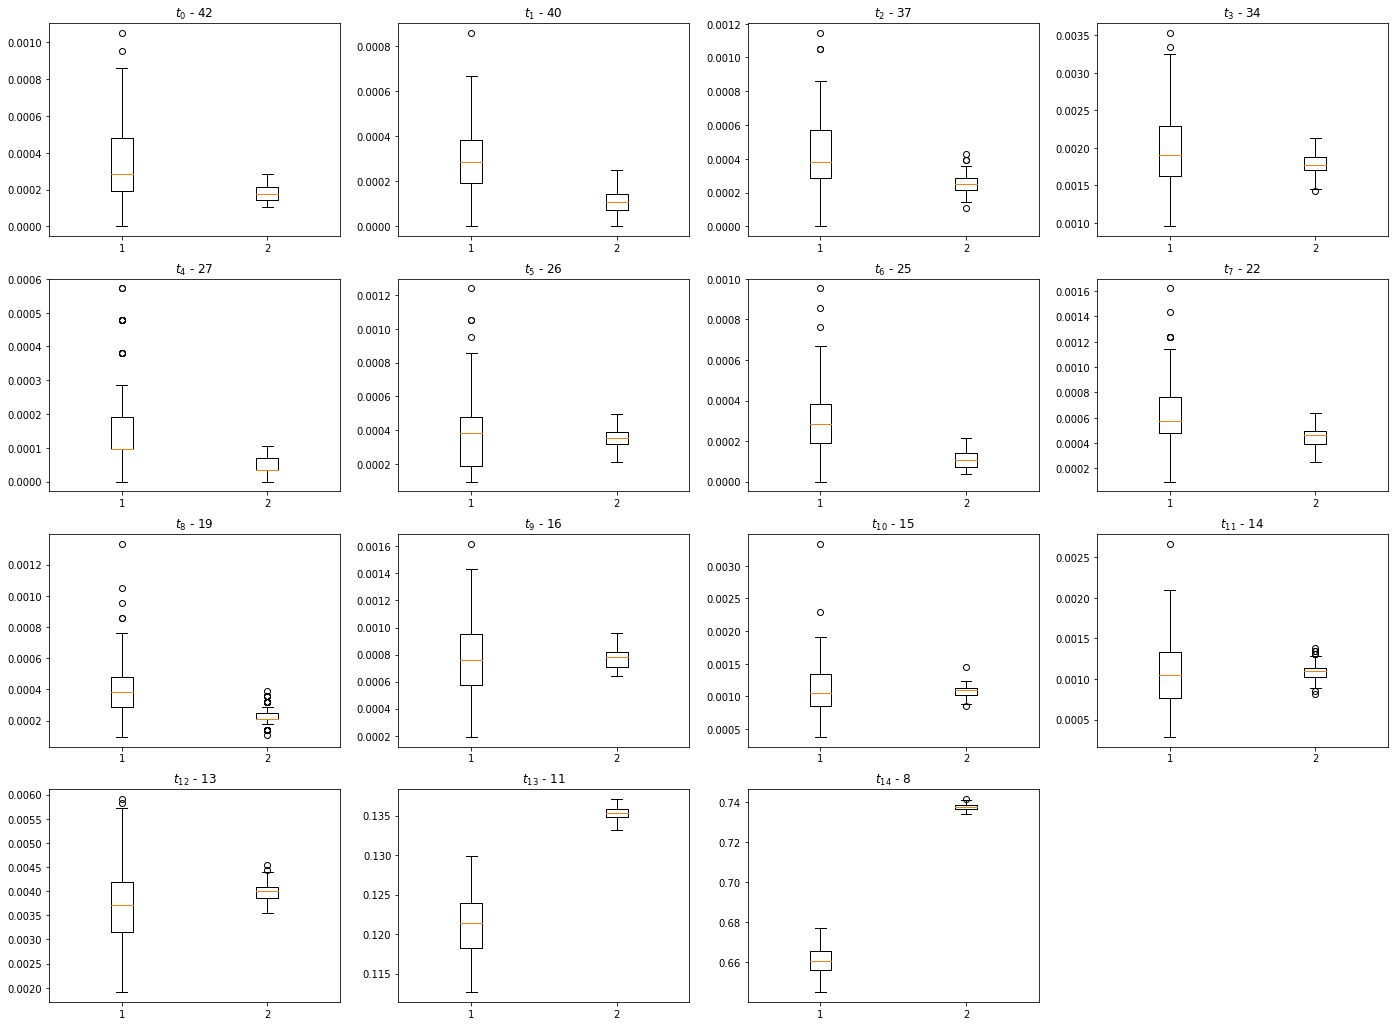

In [90]:
plt.figure(figsize=(24, 18))
for i, t in enumerate(champion_trees[:-1]):
    qlml1 = df[(df.tree_idx==i) & (df.sample_size=='sm')].lml_delta_div_n
    qlml2 = df[(df.tree_idx==i) & (df.sample_size=='lg')].lml_delta_div_n
    plt.subplot(4, np.ceil(len(champion_trees)/4), i+1)
    plt.title('$t_{%s}$ - %s'% (i, len(t.to_str().split(' '))))
    boxplot([qlml1, qlml2])
plt.show()

In [91]:
alpha = 0.01
df2['greater_than_alpha'] = df2.pvalue > alpha
df2

,tree_idx,tvalue,pvalue,sd_sm,sd_lg,num_contexts,greater_than_alpha
0,0.0,13.763987,1.574435e-35,0.000183,0.000038,42.0,False
1,1.0,17.385521,8.981079e-51,0.000144,0.000040,40.0,False
2,2.0,13.161227,4.280959e-33,0.000191,0.000050,37.0,False
3,3.0,4.553612,7.019117e-06,0.000491,0.000121,34.0,False
4,4.0,13.034669,1.372434e-32,0.000111,0.000025,27.0,False
5,5.0,2.471059,1.388922e-02,0.000205,0.000049,26.0,True
6,6.0,17.668258,5.429880e-52,0.000156,0.000037,25.0,False
7,7.0,9.160181,2.773339e-18,0.000264,0.000066,22.0,False
8,8.0,12.606538,6.832286e-31,0.000187,0.000051,19.0,False
9,9.0,0.959354,3.379627e-01,0.000292,0.000064,16.0,True


In [92]:
# take the first tree where 
tree_idx = int(list(df2[df2.pvalue < alpha].tree_idx)[0])
tree_idx

0

In [93]:
champion_trees[tree_idx].to_str()

'0000 0001 0010 002 0030 0102 012 0130 0201 021 0210 03 100 1030 1201 121 1210 13 20 200 2000 2001 2010 2102 212 2130 300 302 3030 32 3201 321 3210 33 330 4 42 4201 421 4210 43 430'

In [94]:
from graphviz import Digraph
t = champion_trees[12].to_str()
print(t)

000 001 10 100 2 20 200 201 21 3 30 300 4


In [95]:
#node_attr={'color': 'lightblue2', 'style': 'filled'}
def draw_tree(tt):
    t = tt.to_str()
    dot = Digraph(engine='dot', name=t)
    dot.attr(size='10,10')
    dot.attr('node', shape='circle')
    contexts = t.split(' ')
    d = []
    dot.node(name='$', label='root')
    for i in range(len(contexts)):
        ctx = contexts[i][::-1]
        ctxl = [(ctx[:i+1], c) for i, c in enumerate(ctx)]
        for node in ctxl:
            dot.node(name=node[0], label=node[1])
            if(len(node[0]))==1:
                if ('$', node[0]) not in d:
                    d.append(('$', node[0]))                
                    dot.edge('$', node[0])
        for pair in list(zip(ctxl, ctxl[1:])):
            n1 = pair[0] 
            n2 = pair[1]
            if (n1, n2) not in d:
                d.append((n1, n2))
                dot.edge(n1[0], n2[0])
    return dot

c =  1.5353562237307417
000 1 10 100 2 20 200 3 30 300 4


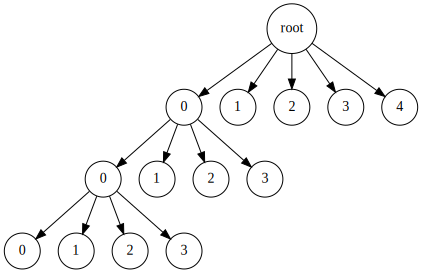

In [96]:
print('c = ', champion_trees[13].chosen_penalty)
print(champion_trees[13].to_str())
draw_tree(champion_trees[13])

c =  1.0361644128459357
000 001 10 100 2 20 200 201 21 3 30 300 4


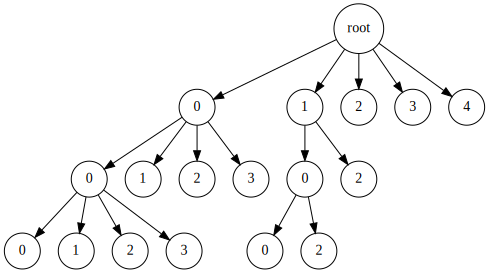

In [97]:
print('c = ', champion_trees[12].chosen_penalty)
print(champion_trees[12].to_str())
draw_tree(champion_trees[12])